## 4. Mini-project: Coordinate descent

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
dataframe = read_csv('heart.csv')
dataframe

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [3]:
# Separate features from labels 
data = dataframe.values
X, y = data[:, :-1], data[:, -1]

### (a) A short, high-level description of your coordinate descent method.
###     In particular, you should give a concise description of how you solve problems (i) and (ii) above. Do you need the function L(·) to be differentiable, or does it work with any loss function?

### (i) Which coordinate to choose?

#### Answer: We will choose the coordinate that minimize the wi by running all coordinates in cyclic order at each iteration.

### (ii) How to set the new value of wi?

#### Answer: For setting the new value of wi, we will use the current value of wi subtract value of the stepsize times gradient.

### Do you need the function L(·) to be differentiable, or does it work with any loss function?

#### Answer: Yes, the function L(·) needs to be differentiable and convex.

### Summary of the coordinate descent method

#### Answer: For the loss function, we will minimize it by minimizing each of the individual dimensions of it in a cyclic fashion, while holding the values of it in the other dimensions fixed.

### (b) Convergence.
### Under what conditions do you think your method converges to the optimal loss? There’s no need to prove anything: just give a few sentences of brief explanation.

#### Answer: After minimizing the cost function with respect to each coordinate, the cost function has bounded level sets and is in some sense strictly convex.

### (c) Experimental results.

#### Begin by running a standard logistic regression solver (e.g., from scikit-learn) on the training set. It should not be regularized: if the solver forces you to do this, just set the regularization constant suitably to make it irrelevant. Make note of the final loss L∗.

In [4]:
# Build logistic regression classifier
clf = LogisticRegression(random_state = 42).fit(X, y)
proba = clf.predict_proba(X)
log_loss_value = log_loss(y, proba)
print('Final loss\n L* =', log_loss_value)

Final loss
 L* = 0.3534163611333882


In [5]:
# normalize data
X_normalize = (X - np.mean(X,axis = 0))/(np.max(X, axis = 0) - np.min(X, axis = 0))
intercept = np.ones((X.shape[0], 1))
intercept = intercept.reshape(X.shape[0], 1)
X_norm = np.hstack((X_normalize, intercept))
X_norm.shape

(303, 14)

#### Then, implement your coordinate descent method and run it on this data.

In [6]:
# predict y
def predict_function(w, x):
    return 1/(1 + (np.exp(-(np.dot(w.T, x.T)))))

# calculate the loss
def loss_function(x, y, y_predict):
    return -(1/x.shape[0]) * np.sum(y * np.log(y_predict) + (1 - y) * np.log(1 - y_predict))

# calculate gradient
def gradient_function(x, y, y_predict):
    return list(np.dot((y_predict-y), x)[0])

In [7]:
# calculate the loss by using the coordinate descent method
def coordinate_descent(x, y, iteration, etha):
    w = np.zeros((x.shape[1],1))
    index = 0
    loss = []
    n = (x.shape[1] - 1)
    
    for i in range(iteration):
        y_predict = predict_function(w, x)
        gradient = gradient_function(x, y, y_predict)
        w[index%n] = w[index%n] - etha*gradient[index%n]
        index += 1     
        loss.append(loss_function(x, y, y_predict))  
    return loss

In [8]:
loss_coordinate_descent = coordinate_descent(X_norm, y, 1000, 0.01)
print('The minimum loss about the coordinate descent is:\n', min(loss_coordinate_descent))

The minimum loss about the coordinate descent is:
 0.35857565006240405


#### Finally, compare to a method that chooses coordinates i uniformly at random and then updates wi using your method (we’ll call this “random-feature coordinate descent”).

In [9]:
def random_coordinate_descent(x, y, number_iteration, etha):
    w = np.zeros((x.shape[1],1))
    loss = [] 
    n = (x.shape[1] - 1)
    
    for i in range(number_iteration):
        y_predict = predict_function(w, x)
        gradient = gradient_function(x, y, y_predict)
        current_index = np.random.randint(0,n)
        w[current_index] = w[current_index] - etha*gradient[current_index] 
        loss.append(loss_function(x, y, y_predict))  
    return loss

In [10]:
loss_random_coordinate_descent = random_coordinate_descent(X_norm, y, 1000, 0.01)
print('The minimum loss about the coordinate descent is:\n', min(loss_random_coordinate_descent))

The minimum loss about the coordinate descent is:
 0.35817122582262023


#### Produce a clearly-labeled graph that shows how the loss of your algorithm’s current iterate— that is, L(wt)—decreases with t; it should asymptote to L∗. On the same graph, show the corresponding curve for random-feature coordinate descent.

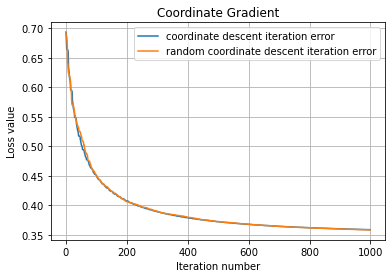

In [11]:
iteration = np.arange(0,1000)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.title('Coordinate Gradient')
plt.plot(iteration, loss_coordinate_descent, label = 'coordinate descent iteration error')
plt.plot(iteration, loss_random_coordinate_descent, label = 'random coordinate descent iteration error')
plt.legend()
plt.grid()
plt.show()